# Toxic Comment Classification

## Project Objective
Classify comments as toxic or non-toxic using multi-label classification. The model should be able to identify various types of toxicity such as toxic, severe toxic, obscene, threat, insult, and identity hate within comments.

### Dataset
The project uses the Jigsaw Toxic Comment Classification dataset from Kaggle, which contains thousands of comments labeled across multiple toxicity categories. The dataset includes:
* Training data with comments and their corresponding toxicity labels.
* Test data without labels for prediction.
* A sample submission file to format your output predictions.

  ### libraries
  pip install pandas numpy spacy matplotlib torch wordcloud transformers scikit-learn joblib

In [2]:
# importing all required libraries
import pandas as pd
import numpy as np
import multiprocessing as mp
import spacy
from tqdm import tqdm
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import torch
import gc
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report, accuracy_score, hamming_loss
import joblib
import joblib

### load dataset

In [3]:
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')

print("Train data shape:", train_df.shape)
print("Test data shape:", test_df.shape)
train_df.head()

Train data shape: (159571, 8)
Test data shape: (153164, 2)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


### Preprocessing Plan for Toxic Comment Dataset

1) Handle Missing Values
* Check if any comment texts are missing and handle them.
  
2) Text Cleaning
* Lowercase all text
* Remove unnecessary characters (punctuation, numbers, special symbols)
* Remove extra whitespace
  
3) Tokenization (using spaCy)
* Split text into meaningful tokens
* Remove stopwords (optional)
* Lemmatization (convert words to base form)

4) Exploratory Data Analysis (Optional but useful)
* Visualize word clouds for toxic vs non-toxic comments
* Check class imbalance

``` save preprocessed dataset ```

In [4]:
missing_count = train_df['comment_text'].isnull().sum()
print(f"Missing values in comment_text: {missing_count}")

train_df['comment_text'] = train_df['comment_text'].fillna("")

print(f"Missing values after replacement: {train_df['comment_text'].isnull().sum()}")

Missing values in comment_text: 0
Missing values after replacement: 0


In [ ]:
# tqdm for multiprocessing
tqdm.pandas()

# This will be loaded inside each process
nlp = None

def init_spacy():
    global nlp
    nlp = spacy.load("en_core_web_sm")

def preprocess_text(text):
    text = text.lower()
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    return " ".join(tokens)

def preprocess_df(df):
    df['clean_comment'] = df['comment_text'].fillna("").progress_apply(preprocess_text)
    return df

def parallelize_dataframe(df, func, n_cores=None):
    if n_cores is None:
        n_cores = mp.cpu_count()
    df_split = np.array_split(df, n_cores)
    with mp.Pool(n_cores, initializer=init_spacy) as pool:
        results = list(tqdm(pool.imap(func, df_split), total=n_cores))
    return pd.concat(results)

def clean_dataset(file_name,multi_processing=True):
    df = pd.read_csv(file_name)
    # Use all CPU cores available
    if not multi_processing:
        init_spacy()
        return preprocess_df(df)
    n_cores = mp.cpu_count()
    # Run preprocessing in parallel with progress bar
    processed_df = parallelize_dataframe(df, preprocess_df, n_cores=n_cores)
    processed_df.to_csv(file_name.replace(".csv","_cleaned.csv"), index=False)
    print(processed_df.head())
    return processed_df
    
train_df = clean_dataset("../data/train.csv",multi_processing = True)
test_df = clean_dataset("../data/test.csv", multi_processing = True)

  1%|▎                                    | 1486/159571 [00:17<27:23, 96.19it/s]

* load saved preprocessed data

In [4]:
train_df = pd.read_csv('../data/train_cleaned.csv')
test_df = pd.read_csv('../data/test_cleaned.csv')

### Exploratory Data Analysis (EDA)

1. Class Distribution
Understand how many comments are toxic, severe toxic, etc.

threat             478
identity_hate     1405
severe_toxic      1595
insult            7877
obscene           8449
toxic            15294
dtype: int64


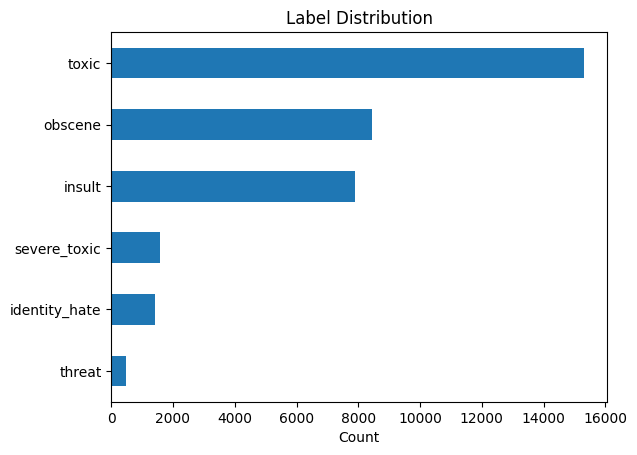

In [5]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
label_counts = train_df[label_cols].sum().sort_values()
print(label_counts)
label_counts.plot(kind='barh', title='Label Distribution')
plt.xlabel("Count")
plt.show()


2. Check Multilabel Overlap
Some comments have more than one toxic label.

In [6]:
train_df['num_labels'] = train_df[label_cols].sum(axis=1)
print(train_df['num_labels'].value_counts())

num_labels
0    143346
1      6360
3      4209
2      3480
4      1760
5       385
6        31
Name: count, dtype: int64


3. Comment Length Distribution

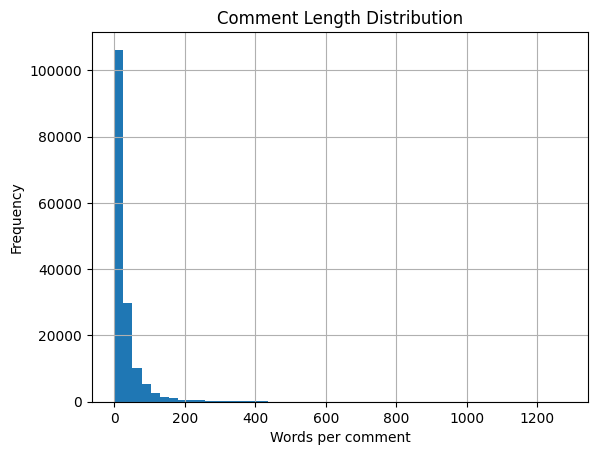

In [7]:
train_df['comment_len'] = train_df['clean_comment'].apply(lambda x: len(str(x).split()))
train_df['comment_len'].hist(bins=50)
plt.title("Comment Length Distribution")
plt.xlabel("Words per comment")
plt.ylabel("Frequency")
plt.show()

4. Word Clouds (for visualizing common toxic vs non-toxic words)

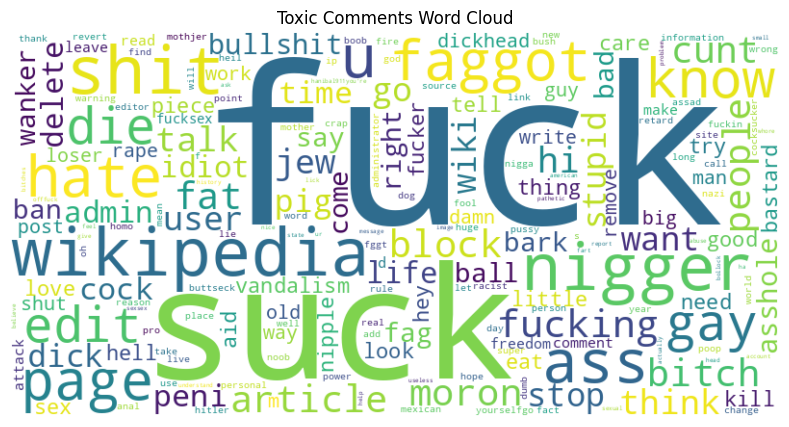

In [8]:
custom_stopwords = set(STOPWORDS)
custom_stopwords.update(["hi", "dont", "youre", "got", "get", "like", "one", "also", "know", "would", "people"])
# Toxic comments only
toxic_comments = " ".join(train_df[train_df['toxic'] == 1]['clean_comment'].astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white',collocations=False).generate(toxic_comments)


plt.figure(figsize=(15, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Toxic Comments Word Cloud')
plt.show()


### Feature Extraction for Toxic Comment Classification

In [13]:
# limit first 1000 data sets
train_df = train_df[:1000]

In [20]:

def extrect_features(df, name):
    # Load Huggingface tokenizer and model (DistilBERT)
    model_name = "distilbert-base-uncased"
    # model_name = "prajjwal1/bert-mini"  # Uncomment for smaller model
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)
    model.eval()  # Inference mode

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("✅ Using device:", device)
    model.to(device)

    # Tokenize texts in batches
    batch_size = 8  # Reduce if you still get memory issues
    all_embeddings = []
    texts = df['clean_comment'].fillna("").astype(str).tolist()

    # Label columns
    label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
    y = df[label_cols].values

    for i in tqdm(range(0, len(texts), batch_size), desc=f"Extracting embeddings for {name}"):
        batch_texts = texts[i:i+batch_size]

        inputs = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=128,
            return_tensors="pt"
        ).to(device)

        with torch.no_grad():
            outputs = model(**inputs)
            embeddings = outputs.last_hidden_state[:, 0, :]  # CLS token
            all_embeddings.append(embeddings.cpu())

        # Clean up to free memory
        del inputs, outputs, embeddings
        torch.cuda.empty_cache()
        gc.collect()

    # Combine all batches
    features = torch.cat(all_embeddings).numpy()

    # Save embeddings and labels to disk
    np.save(f"../features/{name}_bert_features.npy", features)
    np.save(f"../features/{name}_bert_labels.npy", y)
    print("✅ Saved features and labels for:", name)
    print("✅ Embeddings shape:", features.shape)
    print("✅ Labels shape:", y.shape)
    return features, y
# Load and process test data
test_input = pd.read_csv('../data/test_cleaned.csv')
test_label = pd.read_csv('../data/test_labels.csv')
test_df = pd.merge(test_input, test_label, on='id', how='inner')
test_df.head()


X_train, y_train = extrect_features(train_df, "train")
X_test, y_test = extrect_features(test_df, "test")


✅ Using device: cpu


Extracting embeddings for test: 100%|███████████| 63/63 [01:09<00:00,  1.10s/it]

✅ Saved features and labels for: test
✅ Embeddings shape: (500, 768)
✅ Labels shape: (500, 6)


In [4]:
def load_features_and_labels(prefix="train"):
    features = np.load(f"../features/{prefix}_bert_features.npy")
    labels = np.load(f"../features/{prefix}_bert_labels.npy")
    print(f"✅ Loaded: {prefix}_bert_features.npy and {prefix}_bert_labels.npy")
    return features, labels

In [17]:
!pip install scikit-learn joblib

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 2.1 MB/s eta 0:00:002.1 MB/s eta 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.1/35.1 MB 1.3 MB/s eta 0:00:00m eta 0:00:010:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [scikit-learn]0m 3/4 [scikit-learn]


### Train Model

In [18]:
# load features from storage
X_train, y_train = load_features_and_labels(prefix="train")

base_model = LogisticRegression(max_iter=1000)
clf = MultiOutputClassifier(base_model)
clf.fit(X_train, y_train)

# Step 4: Save the trained model
joblib.dump(clf, "../models/logreg_multi_label_model.pkl")
print("✅ Model saved to: ../models/logreg_multi_label_model.pkl")

✅ Loaded: train_bert_features.npy and train_bert_labels.npy
✅ Model saved to: ../models/logreg_multi_label_model.pkl


### Evaluate Model

In [8]:


# Load saved features and labels for test set
X_test, y_test = load_features_and_labels(prefix="test")

# Filter out rows where any label == -1
mask = ~(y_test == -1).any(axis=1)
X_test = X_test[mask]
y_test = y_test[mask]

# Load the trained model from disk
clf = joblib.load("../models/logreg_multi_label_model.pkl")

# Predict on test data
y_pred = clf.predict(X_test)

label_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Print classification report
print("📊 Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_names))

# Additional evaluation metrics (optional)
exact_match = accuracy_score(y_test, y_pred)
hamming = hamming_loss(y_test, y_pred)

print(f"Exact Match Ratio (Accuracy): {exact_match:.4f}")
print(f"Hamming Loss: {hamming:.4f}")

✅ Loaded: test_bert_features.npy and test_bert_labels.npy
📊 Classification Report:
               precision    recall  f1-score   support

        toxic       0.63      0.63      0.63        19
 severe_toxic       0.00      0.00      0.00         0
      obscene       0.86      0.50      0.63        12
       threat       0.00      0.00      0.00         1
       insult       0.67      0.33      0.44        12
identity_hate       0.00      0.00      0.00         4

    micro avg       0.69      0.46      0.55        48
    macro avg       0.36      0.24      0.28        48
 weighted avg       0.63      0.46      0.52        48
  samples avg       0.06      0.05      0.05        48

Exact Match Ratio (Accuracy): 0.8952
Hamming Loss: 0.0286


/home/jenil/Desktop/NLP_project/env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/jenil/Desktop/NLP_project/env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/jenil/Desktop/NLP_project/env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric